# __Upvote Prediction__

###  <font color=blue> __By Lucas Fabre & Tanguy Magon__ </font>

#### __Import packages__

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import scipy
import emoji
import regex
import string
import textstat
import readability
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import time
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Bidirectional, LSTM, Input, Embedding
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

from gensim.models import FastText
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to C:\Users\Tanguy
[nltk_data]     Magon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
path = 'C:\\Users\\Tanguy Magon\\Documents\\M2\\S2\\Web_Mining\\comments_students.csv'

In [4]:
data = pd.read_csv(path)

## __Data Cleansing__

created_utc seems not irrelevant.\
subreddit_id has always the same value.\
subreddit has always the same value.\

In [5]:
data = data.drop(['name','subreddit','subreddit_id','created_utc'], axis = 1)

## __Split into training set and test set__
The comments where ups=np.NaN are the comments in the test set. The other comments are in the training set.

In [6]:
train = data[data['ups'].notnull()]
test = data[data['ups'].isnull()]

#### Count the number of nas for each dataframe

In [7]:
train['body'].isnull().sum()

52

In [8]:
test['body'].isnull().sum()

9

Drop nas in the training set.

In [9]:
train = train.dropna(how='any', subset=['body'])

In [10]:
train['body'].isnull().sum()

0

In [11]:
test.fillna({'body': 'deleted'}, inplace=True)

C:\anconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [12]:
test.isnull().sum()

ups          1016458
link_id            0
id                 0
author             0
body               0
parent_id          0
dtype: int64

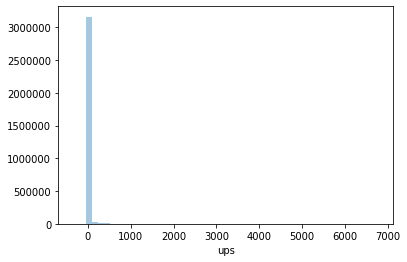

In [13]:
sns.distplot(train['ups'], kde=False)
plt.show()

# __Feature Creation__

###  <font color=blue> __Structural Features__ </font>

In [14]:
train  =  train[~(train.body == ' ')]

In [16]:
def link_presence(data):
    """Create a variable that accounts how many subreddits are in the link id"""
    data['link_presence'] = data.groupby('link_id')['link_id'].transform('count')
    return data

def sentiment(data):
    sentiment_analyzer = SentimentIntensityAnalyzer()
    positive = []
    neutral = []
    negative = []
    compound = []
    for text in data['body']:
        sentiment = sentiment_analyzer.polarity_scores(text)
        positive.append(sentiment['pos'])
        neutral.append(sentiment['neu'])
        negative.append(sentiment['neg'])
        compound.append(sentiment['compound'])
    data['positive_sentiment'] = pd.Series(positive)
    data['neutral_sentiment'] = pd.Series(neutral)
    data['negative_sentiment'] = pd.Series(negative)
    data['compound_sentiment'] = pd.Series(compound)
    return data

def author_presence(data):
    """Create a variable to account for how many times the author posted"""
    data['author_presence'] = data.groupby('author')['author'].transform('count')
    return data

def parent_presence(data):
    """Create a variable that accounts how many subreddits are in the parent element ( link or comment)"""
    data['parent_presence'] = data.groupby('author')['author'].transform('count')
    return data

def reply_to_comment(data):
    """Create a dummy to know if the author replies to a comment inside a link or a link (1 comment, 0 otherwise)"""
    data['reply_comment'] = np.where(data.link_id != data.parent_id, 1, 0)
    return data

def percentage_of_uppercases(data):
    """compute the pourcentage of uppercase letter in a comment"""
    data['percentage_uppercase'] = data['body'].apply(lambda x : 1 if len(list(filter(str.isalpha, x))) == 0 else
                   sum(map(str.isupper, list(filter(str.isalpha, x)))) / len(list(filter(str.isalpha, x))))
    return data

def length_comment(data):
    """give the number of words of a comment"""
    data['len_comment'] = data['body'].apply(len)
    return data

def avg_word(data):
    """average word length"""
    data['avg_word'] = data['body'].apply(lambda x: 1 if len(x.split()) == 0 else sum(len(x.split()) for word in x.split())/len(x.split()))
    return data
    
def readability(data):
    """readability of a comment"""
    data['readability'] = data['body'].apply(lambda x: textstat.flesch_reading_ease(x))
    return data

def question(data):
    """number of question marks"""
    data['number_of_question'] = data['body'].apply(lambda x : x.count("?"))
    return data
    
def exclamation(data):
    """number of exclamtion marks"""
    data['number_of_question'] = data['body'].apply(lambda x : x.count("!"))
    return data

def punctuation(data):
    """count punctuation"""
    count = lambda l1,l2: sum([1 for x in l1 if x in l2]) 
    data['poncuation'] = data['body'].apply(lambda x: count(x,set(string.punctuation)))
    return data


def structural_features(data):
    """Function thats apply the following:
        1. link presence
        2. sentiment
        3. author presence
        4. parent presence
        5. reply to comment
        6. percentage of uppercase
        7. avg word
        8. readability
        9. question
        10. exclamation
        11. punctuation"""
    structural_df = (data
            .pipe(link_presence)
            .pipe(sentiment)
            .pipe(author_presence)
            .pipe(parent_presence)
            .pipe(reply_to_comment)
            .pipe(percentage_of_uppercases)
            .pipe(avg_word)
            .pipe(readability)
            .pipe(question)
            .pipe(exclamation)
            .pipe(punctuation))
    return structural_df

### __Apply structural_features transformation on train and test.__

In [16]:
# initialize parallele computing to save time
from multiprocessing import Pool
p = Pool(3)

In [19]:
train_features = p.map(structural_features, train)
test_features = p.map(structural_features, test)

In [20]:
train_features.to_csv('train_up.csv')
test_features.to_csv('test_up.csv')

# __Stylometric characteristics__

###  <font color=blue> __Text processing__ </font>

In [17]:
def remove_punctuation(data, colname):
    """remove ponctuation from text"""
    data[colname]= data[colname].str.replace(r"[^\w\s]",'')
    return data

def convert_text_to_lowercase(data, colname):
    """Convert text data to lowercase"""
    data[colname] = data[colname].str.lower()
    return data

def remove_digits(data, colname):
    """Remove punctuation ad alphanumeric characters"""
    data[colname] = data[colname].str.replace(r'\d+','')
    return data

def tokenize_sentence(df, colname):
    """Tokenize sentence"""
    df[colname] = df[colname].str.split()
    return df

def remove_stop_words(df, colname):
    """Remove stop words"""
    stop_words= stopwords.words('english')
    df[colname] = df[colname].dropna().apply(lambda x: [word for word in x if word not in stop_words])
    return df

def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].str.join(' ')
    return df

def text_preprocessing(df, colname):
    """pipeline of all the fonctions created:
       1. remove puncuation
       2. convert texte to lowercase
       3. remove digits
       4. tokenize sentence
       5. remove stop words
       6. reverse tokenize sentence"""
    df = (df
        .pipe(remove_punctuation, colname)
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_digits, colname)
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(reverse_tokenize_sentence, colname))
    return df



### __Apply Text processing transformation on train and test.__

In [ ]:
train_preprocessed = text_preprocessing(train,'body')

In [44]:
test_preprocessed = text_preprocessing(test,'body')

C:\anconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\anconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\anconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\anconda3\lib

# __Modelisation__

## __Part 1. Modelsation with structural features using CatBoostRegressor__

In [53]:
train.reset_index(drop = True, inplace = True)

A correlation matrix can give us a good idea about the correlation between each variable and verify if some variables are not too correlated with each other: 

In [ ]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
heat = sns.heatmap(corrmat,  square=True)
plt.show()

Parent presence and author presence are highly correlated with each other so we drop parent presence.

In [ ]:
train = train.drop(["parent_presence"],axis=1)

We can now split our train into two samples to test our model perfomance : 

In [54]:
from sklearn.model_selection import train_test_split
X = train.drop(['ups',"link_id","id","author","parent_id"],axis=1)
Y = train['ups']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 666)

For such regression, and after a benchmark of all the Machine Learning algorithm available, we decided to use CatBoost because it has the best performance among other Gradient Boosting algorithm. \
Also, as the learning is very time consuming, we did not have the time to test all the algorithm. 

In [ ]:
from catboost import CatBoostRegressor

We did a grid search in order to find the best parameters : 

In [ ]:
cat = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(grid, X = X_train, y = y_train, plot=True)

In [ ]:
modelstart= time.time()
cb_model = CatBoostRegressor(iterations=700,
                             learning_rate=0.03,
                             depth=10,
                             eval_metric='MAE',
                            )
cb_model.fit(X_train, y_train,
             eval_set=(X_test,y_test),
             use_best_model=True,
             verbose=True,
             plot=True)

The best MAE was 20.21 which is not good enough for us, and the Kaggle LeaderBoard is much more challenging than that ! \
bestTest = 20.21101802 \
bestIteration = 121

## __Part 2. Modelsation with text processing using LSTM__

As the resutls with CatBoost was not good enough, we decided to test a neural network model using Long Short Term Memory networks. 

To do so, we first need to apply a word embedding using FastText to give a weight matrix to our NN. :

In [ ]:
 # maximum number of words take into account by the model vocabulary
VOCAB_SIZE = 50000
# maximum number of words per reddit comment
MAX_LENGTH = 500
# dimension of the embedding layer in the network
EMBEDDING_DIM = 200

In [ ]:
data = train_cleaned['body'].str.split(' ')

fastText_model = FastText(
    data.astype(str),
    size=EMBEDDING_DIM,
)

The following function was used to build the embedding matrix with fastText: \
(Taken from our deep-learning classes during the first semester)

In [ ]:
def initialize_embedding_with_fastText(tokenizer, word_vectors, vocab_size, embedding_dim):
    """
    Build the embedding matrix with the fastText model to initilize the firt LSTM layer.
    """
    # word index
    word_index = tokenizer.word_index

    # define the number of word to keep (correspond to the input dimension of the model)
    nb_words = min(vocab_size, len(word_vectors.vocab)) + 1

    # initialize the matrix with random numbers
    wv_matrix = (np.random.rand(nb_words, embedding_dim) - 0.5) / 5.0

    # feed the matrix using fastText representation
    for word, i in word_index.items():
        if i >= nb_words:
            continue
        try:
            embedding_vector = word_vectors[word]
            # words not found in embedding index will be all-zeros.
            wv_matrix[i] = embedding_vector
        except:
            pass

    return wv_matrix, nb_words

In [ ]:
# Initilaze embedding matrix with fastText vectorization
wv_matrix, input_size = initialize_embedding_with_fastText(
    tokenizer,
    fastText_model.wv,
    VOCAB_SIZE,
    EMBEDDING_DIM)

### __LSTM Model architecture__

We built a NN with 2 bidirectional LSTM hidden Layers followed with BatchNormalization and SpatialDropout.\
Dropout randomly shuts down some neurons in each iteration, we choose to shutdown 0.3 of them \
Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. (by subtracting the batch mean and dividing by the batch standard deviation). It consequently stabilize the learning process and reduces the training time. \

As our machine was not enough powerful to execute such computation, we run this NN with Google Colab on a GPU

In [ ]:
def build_lstm_mode_with_fastText(number_of_classes, wv_matrix, VOCAB_SIZE, MAX_LENGTH, EMBEDDING_DIM):

    inp = Input(shape=(MAX_LENGTH, ))

    x = Embedding(input_dim=VOCAB_SIZE,
                  output_dim=EMBEDDING_DIM,
                  input_length=MAX_LENGTH,
                  weights=[wv_matrix],
                  trainable=False)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(LSTM(300, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(LSTM(300))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    #x = Bidirectional(LSTM(128))(x)
    out = Dense(number_of_classes, kernel_initializer='normal',activation='linear')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    return model

In [ ]:
lstm_model_fastText = build_lstm_mode_with_fastText(
    1,
    wv_matrix,
    input_size,
    MAX_LENGTH,
    EMBEDDING_DIM) 

In [ ]:
history = lstm_model_fastText.fit(
    padded_data_sequences_train,
    train_cleaning.ups,
    epochs=2,
    batch_size=1024,
    verbose=1,
    validation_split=0.1
)

With this architecture we get the best results with a MAE on the validation test set of 12.03 ! \
val_loss: 12.0330 - val_mean_absolute_error: 12.0330

## __Submission process__

In [ ]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'id':test_cleaning.id,'predicted':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

predictions = lstm_model_fastText.predict(test_cleaning)
make_submission(predictions[:,0],'submissionLSTM')

We also tried to to a Tf idf model structure with the following function but it was too long to realize and even in google colab we did not have enoug RAM to apply it

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_features(X_train, X_test, ngram = (1,2), maxdf = 0.7, mindf = 10):
    """X_train, X_test -- samples
    return TF-IDF vectorized representation of each sample and vocabulary"""
    tfidf_vectorizer = TfidfVectorizer(token_pattern = '(\S+)', ngram_range = ngram, max_df = maxdf, min_df = mindf)
    txt_fitted = tfidf_vectorizer.fit(X_train)
    
    X_train = txt_fitted.transform(X_train)
    X_test = txt_fitted.transform(X_test)
    
    return X_train, X_test, tfidf_vectorizer.vocabulary_

In [27]:
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test, ngram = (1,2), maxdf = 0.99, mindf = 10)